<h1> Advanced topics in Time Series Analyis: </h1>

- Check for Stationarity
- Vector Auto Regression (VAR) Model
- Structural VAR analysis: Impulse Response Function (IRF), Forecast Error Variance Decomposition (FEVD)

- Granger Causality Test
- Convergent Cross Mapping (CCM) - Advanced Causality
- Machine Learning Based Forecasting - LightGBM, Random Forest Regressor
- Causality based on Bayesian Network Model - Structure Learning, CausalNex
- Interpretability & Explainability with SHAP

In [ ]:
!pip install statsmodels

In [52]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import mvts_utils as utils
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
%reload_ext autoreload

In [5]:
!pip install openpyxl

In [6]:
import openpyxl

In [7]:
aq_df = pd.read_excel("./data/AirQualityUCI/AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])\
            .set_index('Date_Time').replace(-200, np.nan).interpolate()
aq_df.head(2)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
2004-03-10 19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487


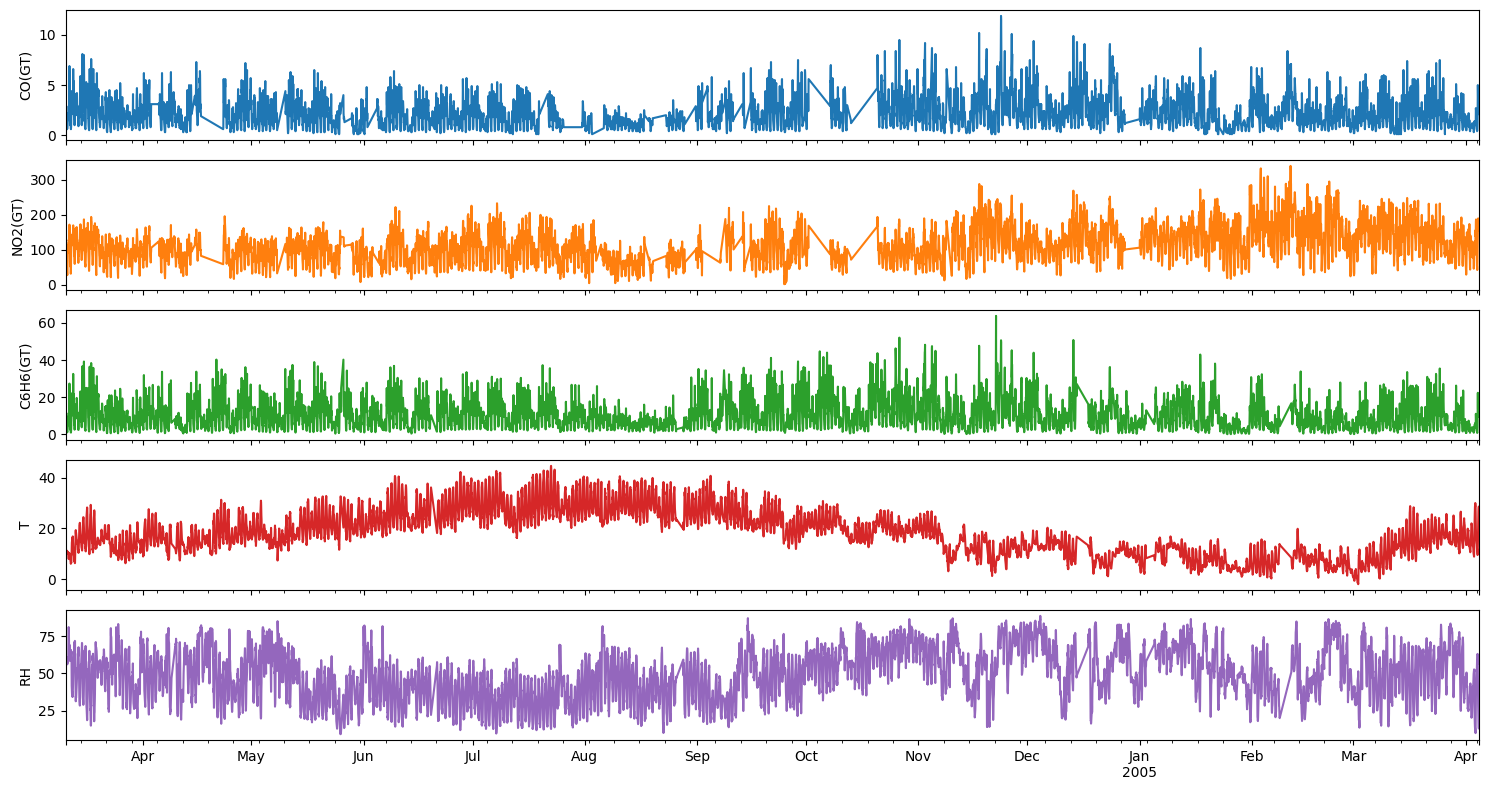

In [8]:
fig,ax = plt.subplots(5, figsize=(15,8), sharex=True)
plot_cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']
aq_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [9]:
ind_df = pd.read_csv('./data/WorldBankHealth/WorldBankHealthPopulation_SeriesSummary.csv')\
            .loc[:,['series_code', 'indicator_name']].drop_duplicates().reindex()\
            .sort_values('indicator_name').set_index('series_code')
hn_df = pd.read_csv('./data/WorldBankHealth/WorldBankHealthPopulation_HealthNutritionPopulation.csv')\
            .pivot(index='year', columns='indicator_code', values='value')

cols = ['SH.XPD.KHEX.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.GHED.GD.ZS']
health_expenditure_df = hn_df.loc[np.arange(2000, 2018), cols]\
    .rename(columns = dict(ind_df.loc[cols].indicator_name\
                           .apply(lambda x: '_'.join(x.split('(')[0].split(' ')[:-1]))))
health_expenditure_df.index = pd.date_range('2000-1-1', periods=len(health_expenditure_df), freq="A-DEC")
health_expenditure_df.head(3)

indicator_code,Capital_health_expenditure,Current_health_expenditure,Domestic_general_government_health_expenditure
2000-12-31,0.013654,3.154818,1.400685
2001-12-31,0.012675,2.947059,1.196554
2002-12-31,0.018476,2.733301,1.012481


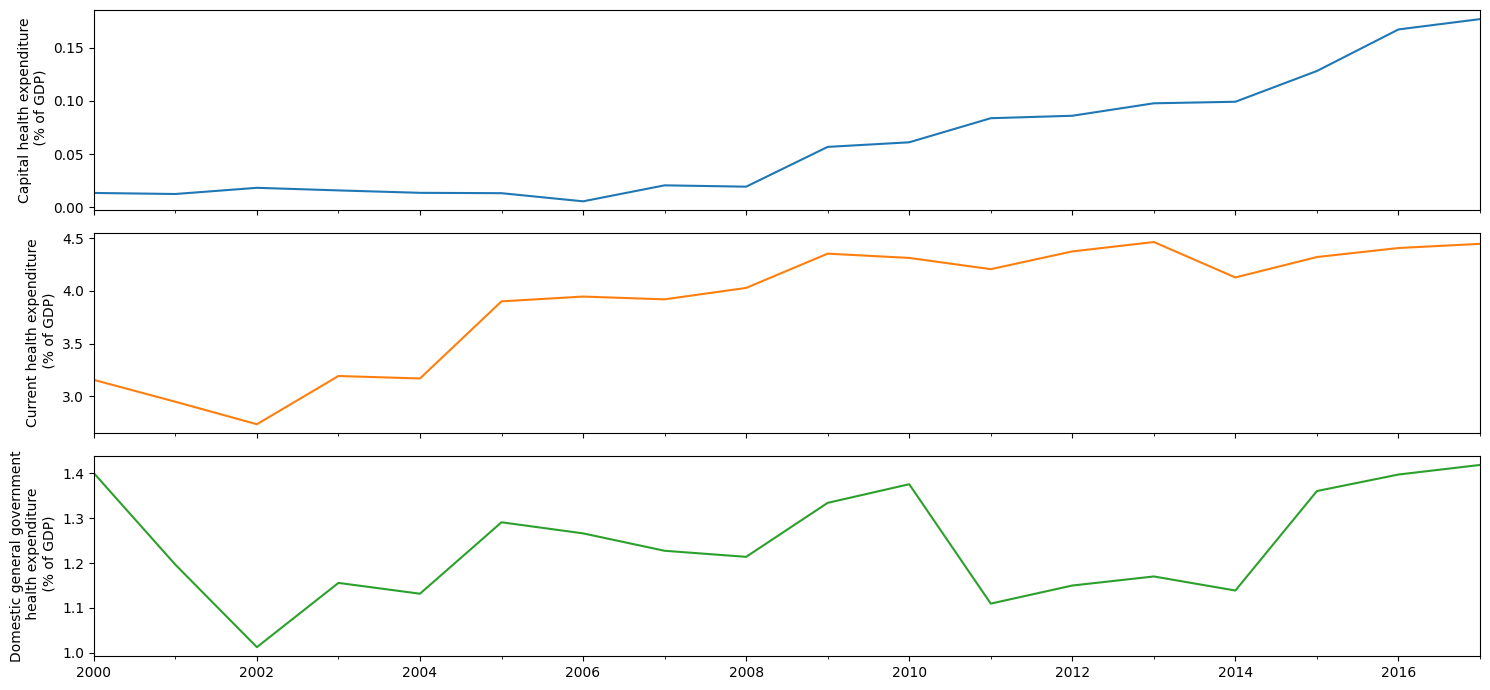

In [10]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,7))
health_expenditure_df.plot(subplots=True, ax=ax, legend=False)
y_label = ['Capital health expenditure', 'Current health expenditure',
           'Domestic general government\n health expenditure']
for a in range(len(ax)): 
    ax[a].set_ylabel(f"{y_label[a]}\n (% of GDP)")
plt.tight_layout()
plt.show()

In [11]:
treas_df = pd.read_excel("./data/USTreasuryRates/us-treasury-rates-weekly.xlsx")
treas_df = treas_df.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
treas_df.index = pd.to_datetime(treas_df.index)
treas_df.head(3)

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,Excess CRSP Mkt Returns,10-year Treasury Returns,Term spread,Change in term spread,5-year Treasury Returns,Unnamed: 15,Excess 10-year Treasury Returns,Term Spread,VXO,Delta VXO
Date,,,,,,,,,,,,,,,,,,,
1982-01-08,10.296,12.08,13.36,13.80,14.12,14.32,14.46,14.54,14.47,-1.632,NaN,2.39,NaN,NaN,NaN,-0.286662,1.729559,20.461911,-0.003106
1982-01-15,10.296,12.72,13.89,14.39,14.67,14.73,14.79,14.84,14.76,-2.212,-2.9,2.04,-0.35,1.65,-2.556,-3.758000,4.464000,NaN,NaN
1982-01-22,10.296,13.47,14.30,14.72,14.93,14.92,14.81,14.80,14.73,-0.202,0.3,1.26,-0.78,0.10,0.049,-0.558000,4.434000,NaN,NaN


In [12]:
treas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 1982-01-08 to 2016-12-30
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   1-month                          1826 non-null   float64
 1   3-month                          1826 non-null   float64
 2   6-month                          1826 non-null   float64
 3   1-year                           1826 non-null   float64
 4   2-year                           1826 non-null   float64
 5   3-year                           1826 non-null   float64
 6   5-year                           1826 non-null   float64
 7   7-year                           1826 non-null   float64
 8   10-year                          1826 non-null   float64
 9   Excess CRSP Mkt Returns          1826 non-null   float64
 10  10-year Treasury Returns         1825 non-null   float64
 11  Term spread                      1826 non-null   float64
 12  Ch

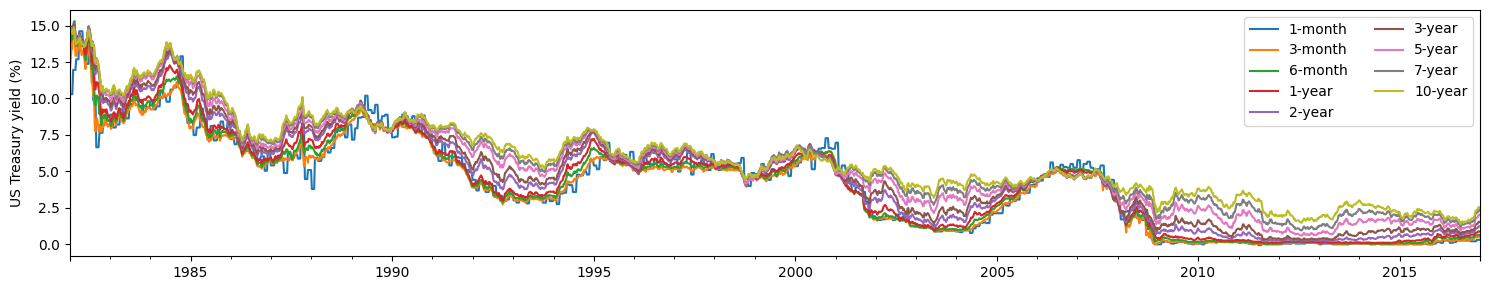

In [13]:
fig,ax = plt.subplots(1, figsize=(15, 3), sharex=True)
data_df = treas_df.iloc[:, 0:9]
data_df.plot(ax=ax)
plt.ylabel('US Treasury yield (%)')
plt.xlabel('')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [14]:
date_format = "%d.%m.%Y %H:%M:%S"

jena_data = pd.read_csv('./data/jena_climate_2009_2016.csv')
jena_data['Date Time'] = pd.to_datetime(jena_data['Date Time'], format=date_format)
jena_data = jena_data.set_index('Date Time')
jena_data.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


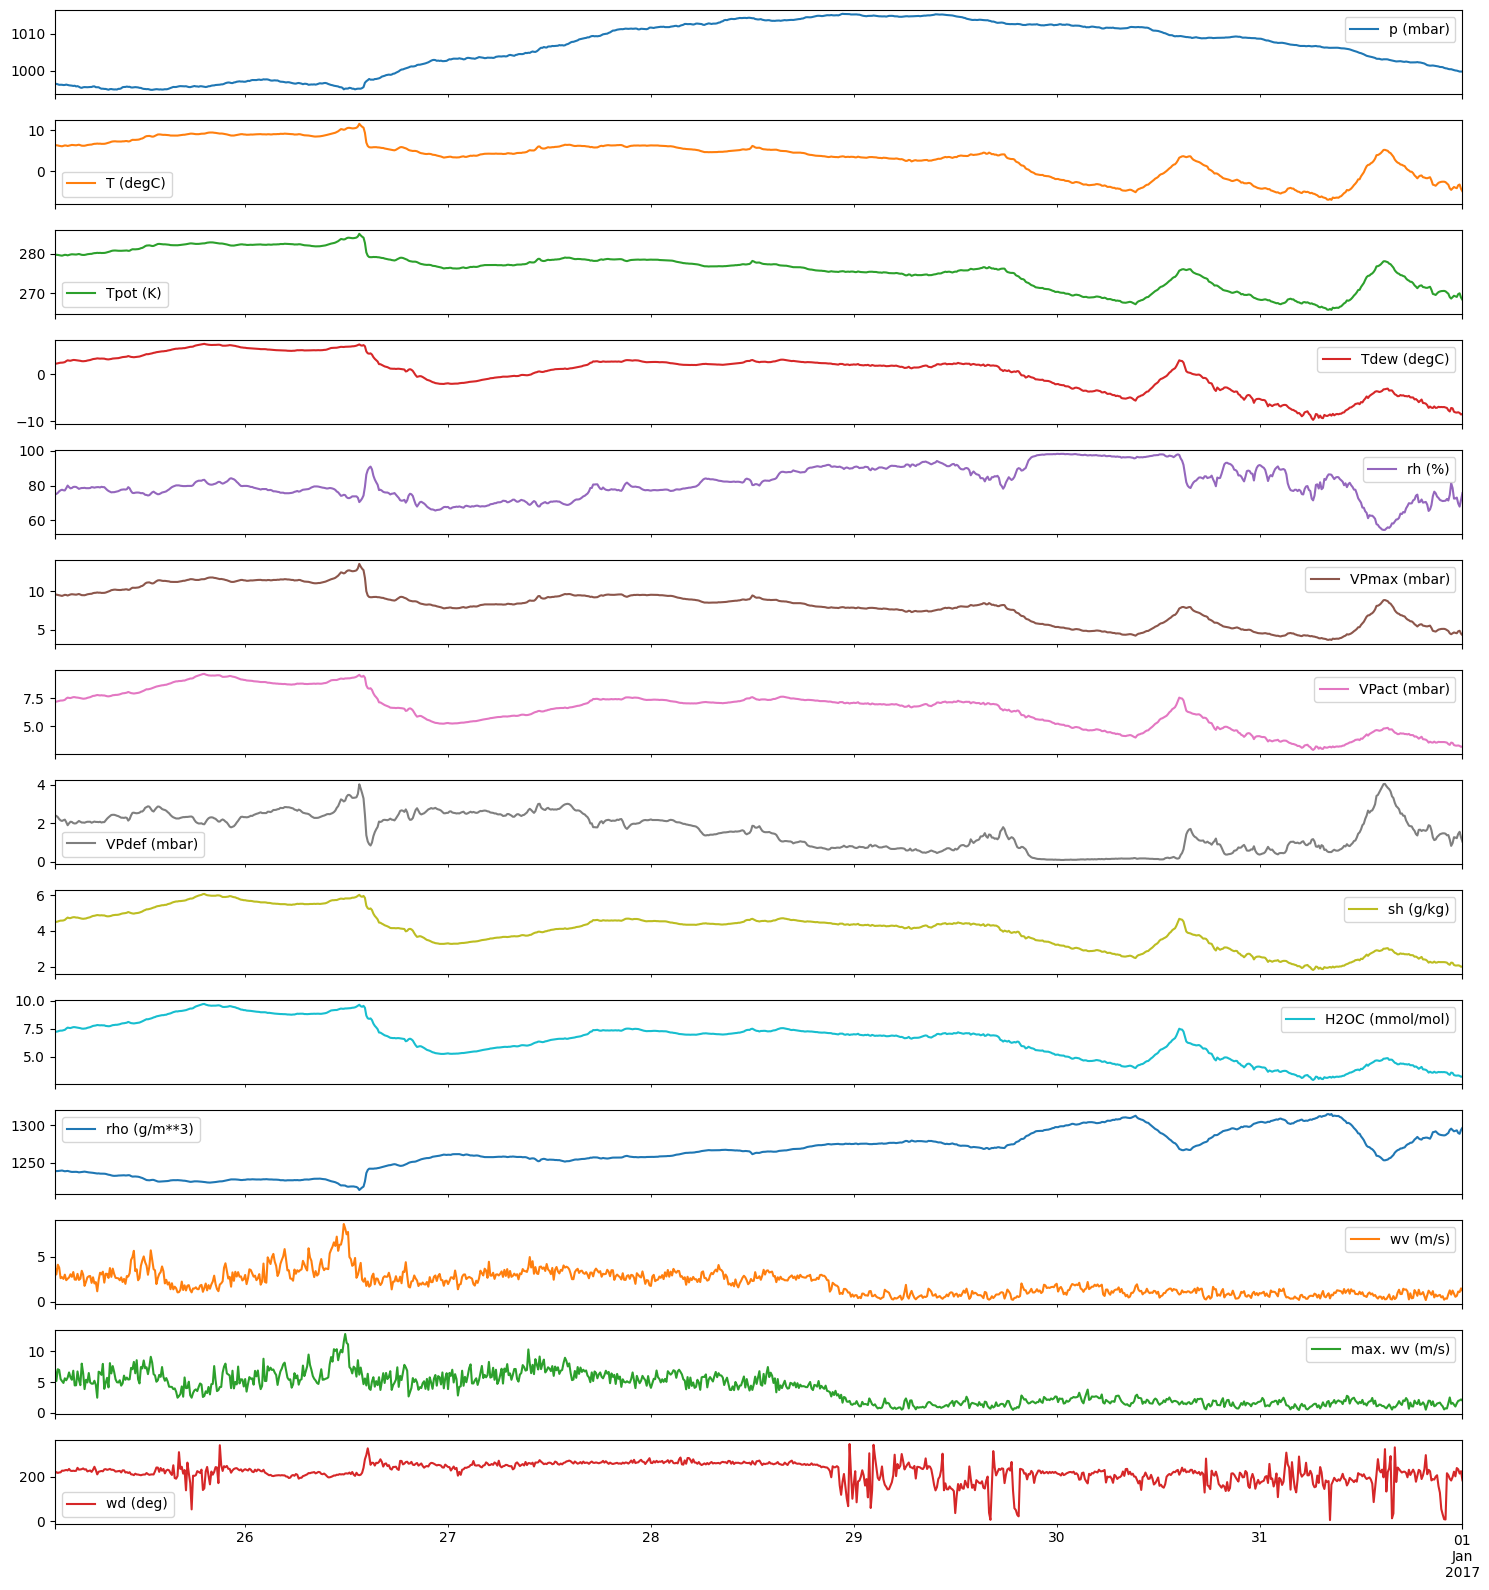

In [15]:
fig,ax = plt.subplots(jena_data.shape[-1], figsize=(15,16), sharex=True)
jena_data.iloc[-1000:].plot(subplots=True, ax=ax)
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

## Building a VAR model
In this section, we show how we can use the VAR model to forecast the air quality data. The following steps are shown below:

    - Check for stationarity.

    - Split data into train and test sets.

    - Select the VAR order p that gives.

    - Fit VAR model of order p on the train set.

    - Generate forecast.

    - Evaluate model performance.



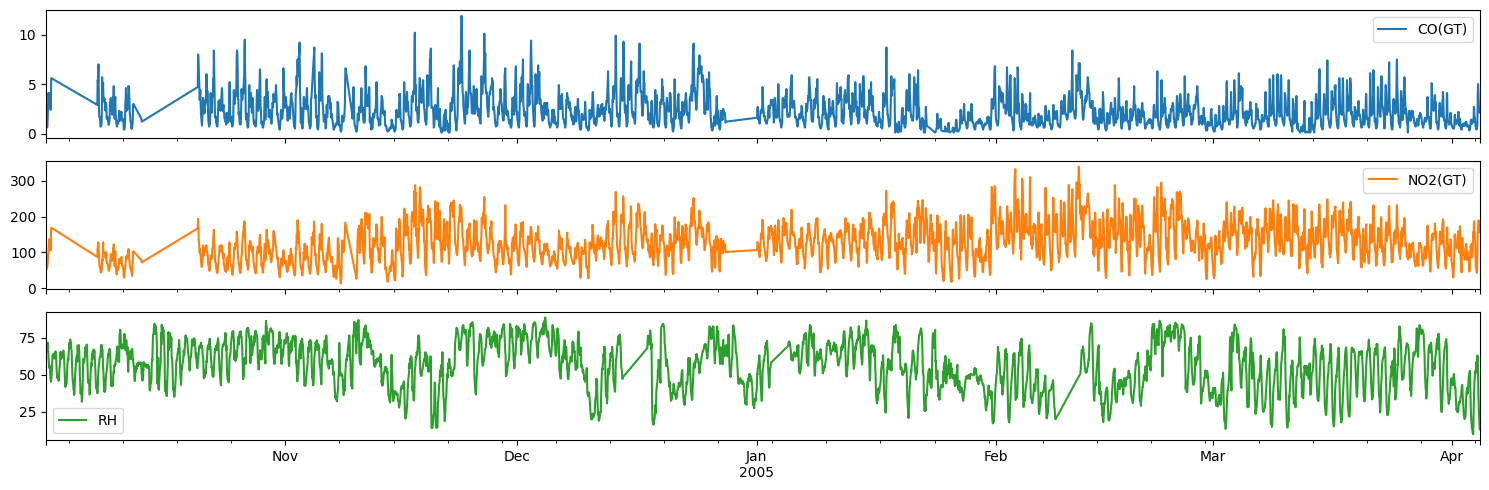

In [16]:
cols = ['CO(GT)', 'NO2(GT)', 'RH']
data_df = aq_df.loc[aq_df.index>'2004-10-01',cols]
fig,ax = plt.subplots(3, figsize=(15,5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

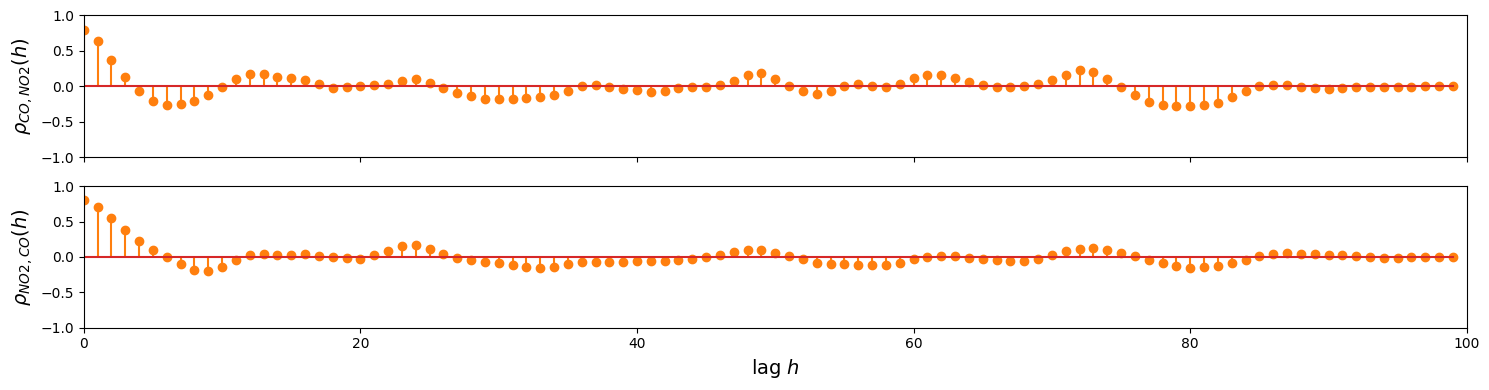

In [17]:
sample_df = data_df.iloc[-100:]
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

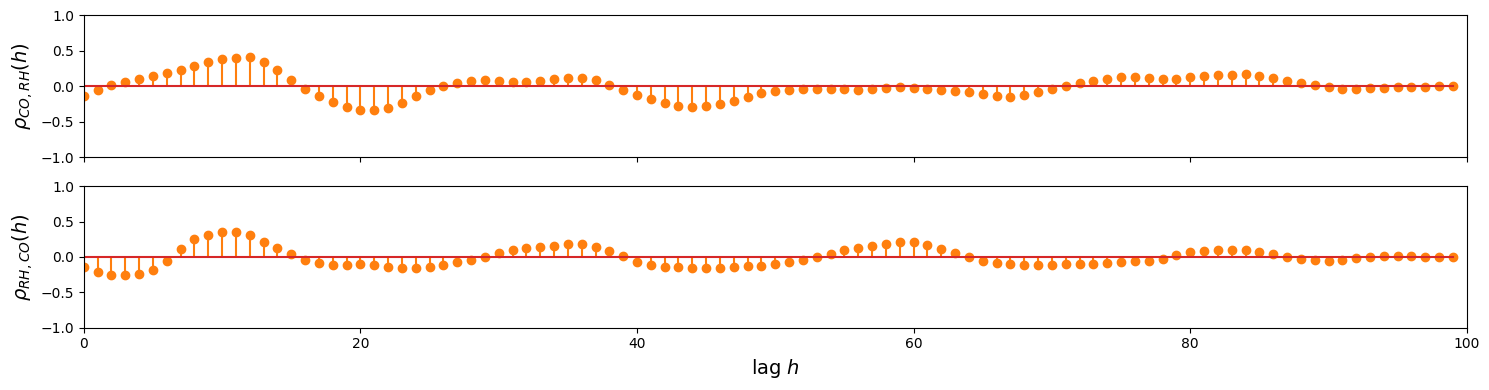

In [18]:
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['RH'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['RH'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,RH} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{RH,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

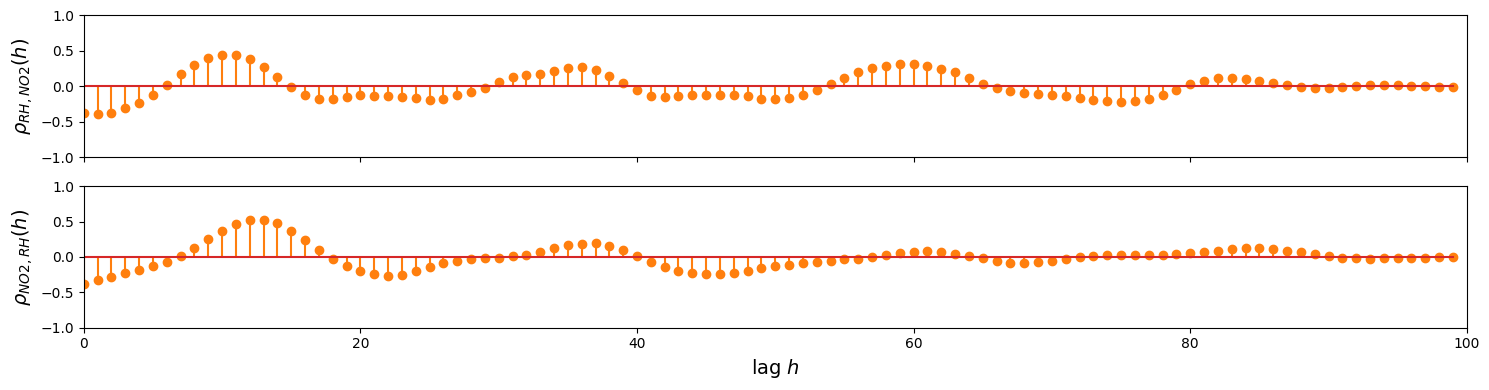

In [19]:
ccf_y1_y2 = ccf(sample_df['RH'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['RH'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{RH,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,RH} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

Observation/s:
As shown in the plot above, we can see that there’s a relationship between:
- CO and some lagged values of RH and NO2
- NO2 and some lagged values of RH and CO
- RH and some lagged values of CO and NO2

This shows that we can benefit from the multivariate approach, so we proceed with building the VAR model.



<b> 1. Check stationarity </b>

To check for stationarity, we use the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test and the Augmented Dickey-Fuller (ADF) test. For the data to be suitable for VAR modelling, we need each of the variables in the multivariate time series to be stationary. In both tests, we need the test statistic to be less than the critical values to say that a time series (a variable) to be stationary.



<b> Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test </b>

Recall: Null hypothesis is that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

In [20]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in data_df.columns: 
    kpss_res = kpss(data_df[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
kpss_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,0.0689,0.3172,0.1026
p-value,0.1000,0.0100,0.1000
Critical value - 1%,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190


Observation/s:

From the KPSS test, CO and RH are stationary.

<b> Augmented Dickey-Fuller (ADF) test </b>

Recall: Null hypothesis is that a unit root is present in a time series sample against the alternative that the time series is stationary.

In [21]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in data_df.columns: 
    adf_res = adfuller(data_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
adf_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,-7.0195,-6.7695,-6.8484
p-value,0.0000,0.0000,0.0000
Critical value - 1%,-3.4318,-3.4318,-3.4318
Critical value - 5%,-2.8622,-2.8622,-2.8622
Critical value - 10%,-2.5671,-2.5671,-2.5671


From the ADF test, CO, NO2 and RH are stationary.


<b> 2. Split data into train and test sets </b>

We use the dataset from 01 October 2014 to predict the last 24 points (24 hrs/1 day) in the dataset.

In [22]:
forecast_length = 24 
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

In [23]:
train_df.reset_index().to_csv('./data/AirQualityUCI/train_data.csv')
test_df.reset_index().to_csv('./data/AirQualityUCI/test_data.csv')

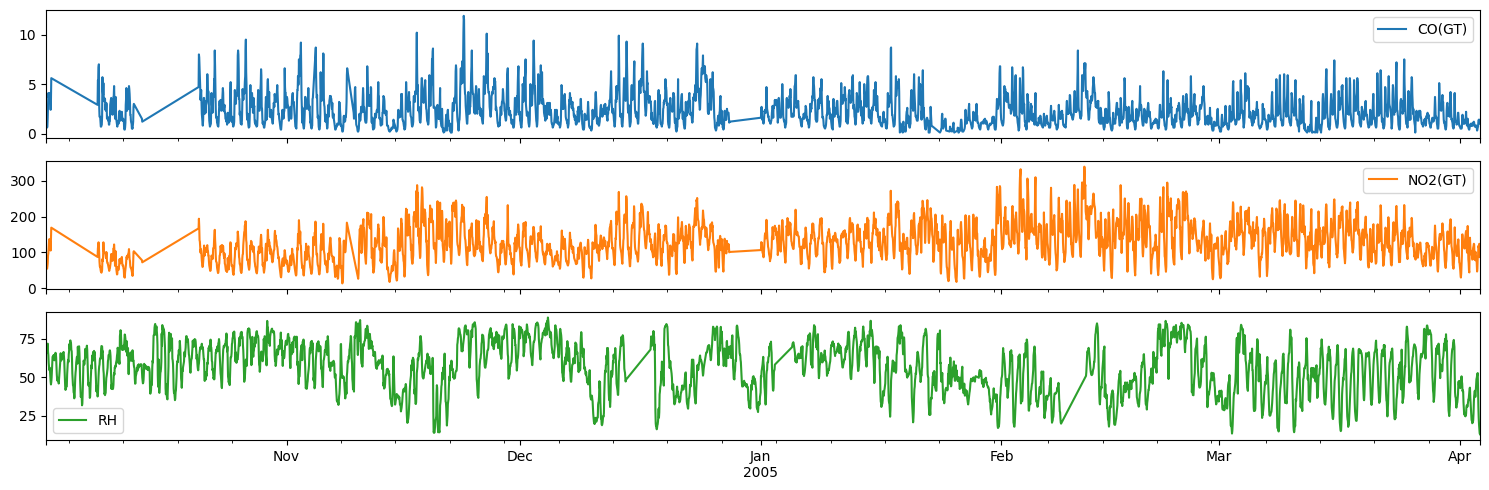

In [24]:
fig,ax = plt.subplots(3, figsize=(15, 5), sharex=True)
train_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

<b> 3. Select order p </b>

We compute the different multivariate information criteria (AIC, BIC, HQIC), and FPE. We pick the set of order parameters that correspond to the lowest values.

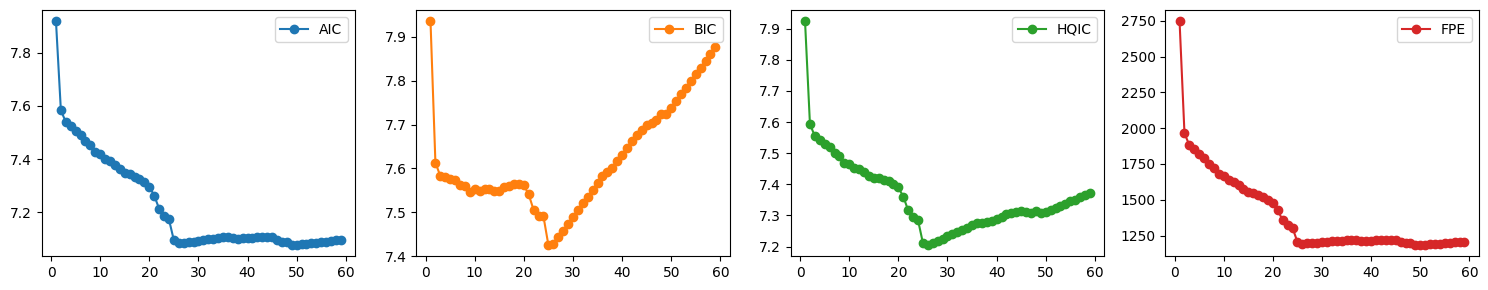

In [25]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

In [55]:
lags_metrics_df.idxmin()

AIC     50
BIC     25
HQIC    26
FPE     50
dtype: int64

In [56]:
lags_metrics_df[25:].idxmin()

AIC     50
BIC     26
HQIC    26
FPE     50
dtype: int64

Observation/s:

We find BIC and HQIC to be lowest at p=26
, and we also observe an elbow in the plots for AIC, and FPE, so we choose the number of lags to be 26.



In [26]:
%%time
var_model = model.fit(26)
var_model.summary()

CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 417 ms


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct, 2024
Time:                     03:21:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.42717
Nobs:                     4404.00    HQIC:                   7.20458
Log likelihood:          -34107.4    FPE:                    1191.88
AIC:                      7.08328    Det(Omega_mle):         1129.97
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.241332         0.069966            3.449           0.001
L1.CO(GT)           0.961418         0.019229           49.999           0.000
L1.NO2(GT)          0.001992         0.000713            2.794     

<b> 4. Get forecast </b>

In [28]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

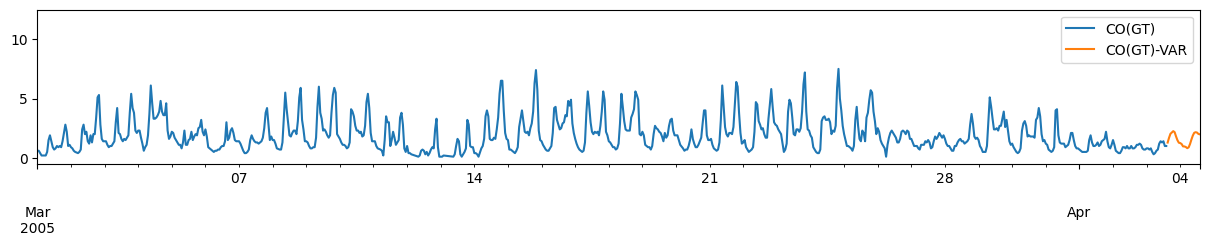

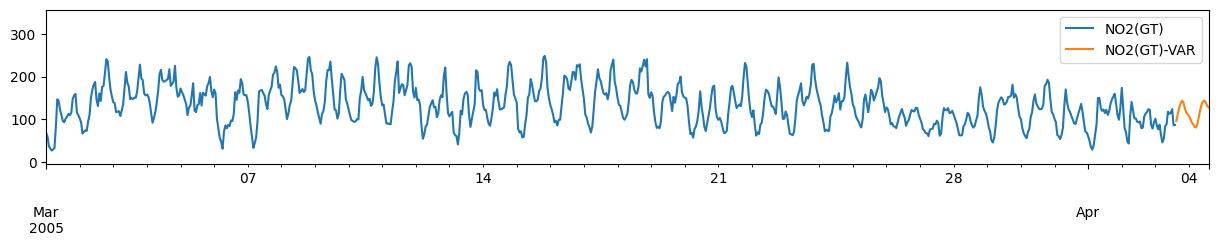

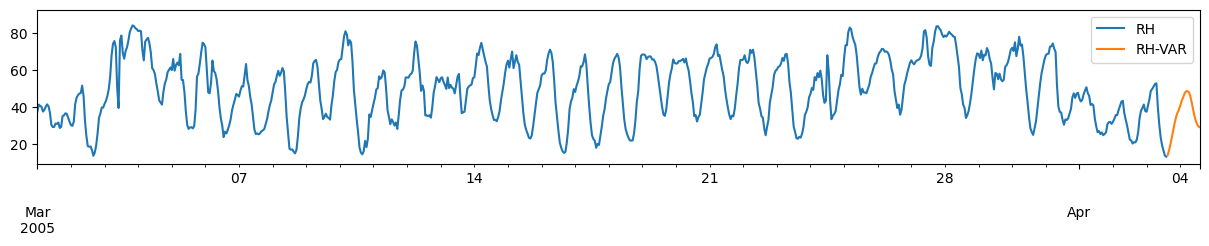

In [29]:
for c in train_df.columns:
    fig, ax = plt.subplots(figsize=[15, 2])
    pd.concat([train_df[[c]], forecast_var[[c+'-VAR']]], axis=1).plot(ax=ax)
    plt.xlim(left=pd.to_datetime('2005-03-01'))
    plt.xlabel('')
#     plt.tight_layout()
    plt.show()

Performance Evaluation: Comparison with ARIMA model

When using ARIMA, we treat each variable as a univariate time series, and we perform the forecasting for each variable: 1 for CO, 1 for NO2, and 1 for RH

In [30]:
# For model order selection, refer to Chapter 1
selected_order = {'CO(GT)': [(0, 1, 0)],
                  'NO2(GT)': [(0, 1, 0)],
                  'RH': [(3, 1, 1)]}

In [48]:
## Import the library 
# from pmdarima import auto_arima 
  
# # Ignore harmless warnings 
# import warnings 
# warnings.filterwarnings("ignore") 

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA

# model = SARIMAX(train['# Passengers'],  
#                 order = (0, 1, 1),  
#                 seasonal_order =(2, 1, 1, 12)) 
  
# result = model.fit() 
# result.summary() 

In [46]:
%%time
forecast_arima = {}
for c in cols:
    model = ARIMA(train_df[c].values, order=selected_order[c][0])
    model_fit = model.fit()
    print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4430
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5315.374
Date:                Tue, 08 Oct 2024   AIC                          10632.748
Time:                        03:59:44   BIC                          10639.144
Sample:                             0   HQIC                         10635.003
                               - 4430                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6456      0.007     89.514      0.000       0.631       0.660
Ljung-Box (L1) (Q):                 206.70   Jarque-Bera (JB):              5061.14
Prob(Q):                              0.00   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4430
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -12454.074
Date:                Tue, 08 Oct 2024   AIC                          24918.147
Time:                        03:59:45   BIC                          24950.127
Sample:                             0   HQIC                         24929.425
                               - 4430                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1922      0.409      0.470      0.638      -0.609       0.993
ar.L2          0.0590      0.147      0.401      0.689      -0.230       0.348
ar.L3          0.0325      0.014      2.355      0.0

In [54]:
%%time
forecast_arima = {}
for c in cols:
    forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
                                                      test_df[c].values, 
                                                      order=selected_order[c][0])
forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)
forecast_arima.head()

CPU times: user 480 ms, sys: 3.96 ms, total: 484 ms
Wall time: 300 ms


,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
Date_Time,,,
2005-04-03 15:00:00,1.0,87.0,12.782563
2005-04-03 16:00:00,1.0,87.0,12.782563
2005-04-03 17:00:00,1.0,87.0,12.782563
2005-04-03 18:00:00,1.0,87.0,12.782563
2005-04-03 19:00:00,1.0,87.0,12.782563


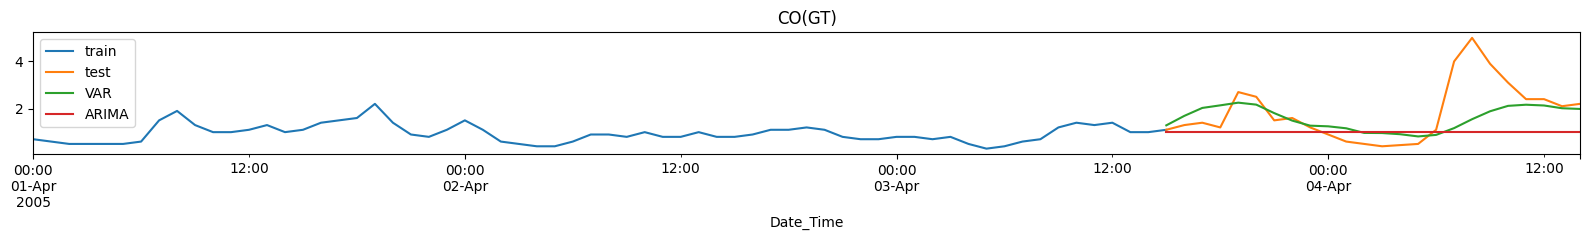

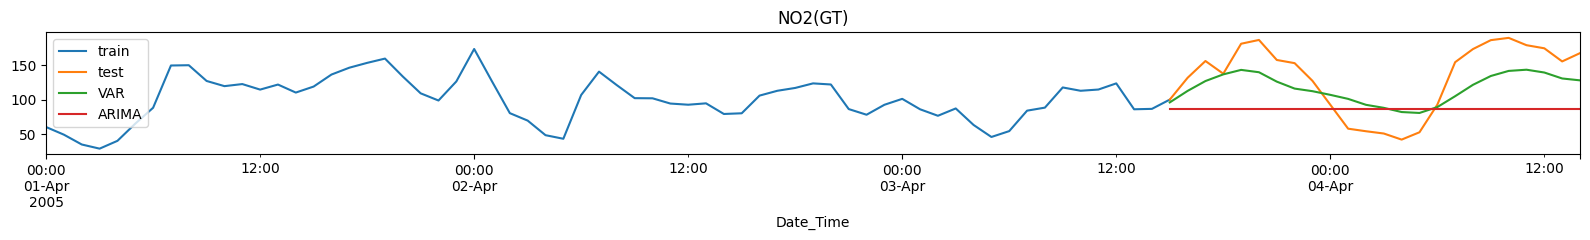

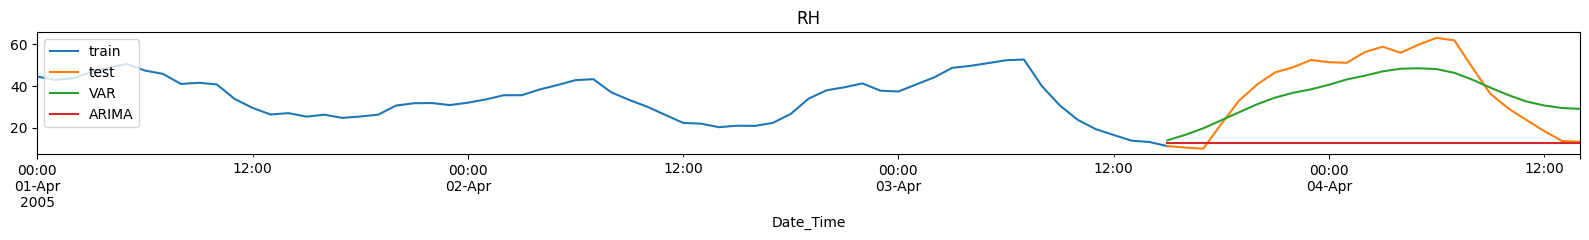

In [57]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          min_train_date='2005-04-01', 
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)

In [58]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

,CO(GT)-VAR,NO2(GT)-VAR,RH-VAR,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
MAE,0.685005,31.687612,9.748883,1.056250,59.304167,25.998494
MSE,1.180781,1227.046604,111.996306,2.159271,4408.539583,983.998967
MAPE,43.508500,29.811066,35.565987,56.985574,46.193861,56.730087


Observation/s:

- MAE: VAR forecasts have lower errors than ARIMA forecasts for CO and NO2 but not in RH.
- MSE: VAR forecasts have lower errors for all variables (CO, NO2 and RH).
- MAPE: VAR forecasts have lower errors for all variables (CO, NO2 and RH).
- Training time is significantly reduced when using VAR compared to ARIMA (<0.1s run time for VAR while ~20s for ARIMA)

<b> Structural VAR Analysis </b>

In addition to forecasting, VAR models are also used for structural inference and policy analysis. In macroeconomics, this structural analysis has been extensively employed to investigate the transmission mechanisms of macroeconomic shocks (e.g., monetary shocks, financial shocks) and test economic theories. There are particular assumptions imposed about the causal structure of the dataset, and the resulting causal impacts of unexpected shocks (also called innovations or perturbations) to a specific variable on the different variables in the model are summarized. 

In this section, we cover two of the common methods in summarizing the effects of these causal impacts: 

(1) impulse response functions, 

(2) forecast error variance decompositions.



<h3> Impulse Response Function (IRF) </h3>

Coefficients of the VAR models are often difficult to interpret so practitioners often estimate the impulse response function.

IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.

IRF traces out the response of the dependent variable of the VAR system to shocks (also called innovations or impulses) in the error terms.



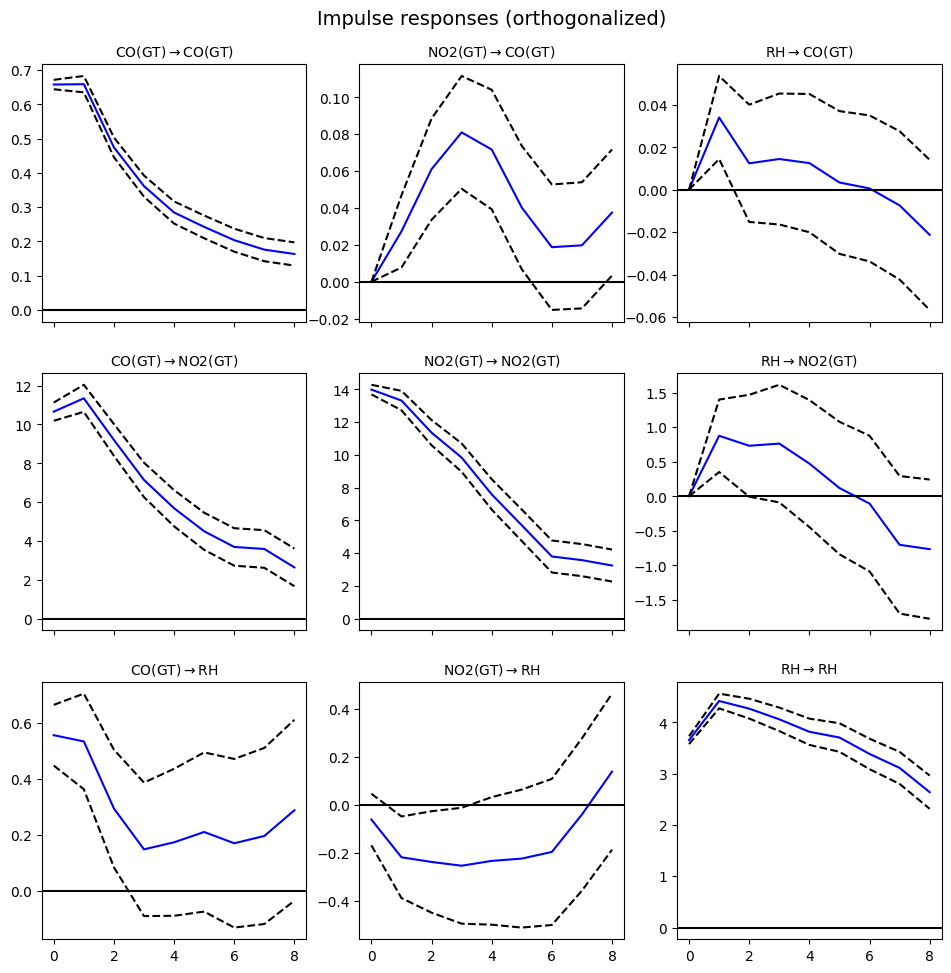

In [59]:
irf = var_model.irf(periods=8)
ax = irf.plot(orth=True, 
              subplot_params={'fontsize': 10})

<h5> Observation/s: </h5>

- Effects of exogenous perturbation/shocks (1SD) of a variable on itself:

CO →
 CO: A shock in the value of CO has a larger effect CO in the early hours but this decays over time.

NO2 →
 NO2: A shock in the value of NO2 has a larger effect NO2 in the early hours but this decays over time.

RH →
 RH: A shock in the value of RH has a largest effect in RH after 1 hour and this effect decays over time.

- Effects of exogenous perturbation/shocks of a variable on another:

CO →
 NO2: A shock in the value of CO has a largest effect in NO2 after 1 hour and this effect decays over time.

CO →
 RH: A shock in the value of CO has an immediate effect in the value of RH. However, the effect decreases immediately after an hour, and the value seems to stay at around 0.2.

NO2 →
 CO: A shock in NO2 only causes a small effect in the values of CO. There seems to be a delayed effect, peaking after 3 hours, but the magnitude is still small.

NO2 →
 RH: A shock in NO2 causes a small (negative) effect in the values of RH. The magnitude seems to decline further after 6 hours. The value of the IRF reaches zero in about 7 hours.

RH →
 CO: A shock in RH only causes a small effect in the values of CO.

RH →
 NO2: A shock in the value of RH has a largest effect in NO2 after 1 hour and this effect decays over time. The value of the IRF reaches zero after 6 hours.



<h3> Forecast Error Variance Decomposition (FEVD)


FEVD indicates the amount of information each variable contributes to the other variables in the autoregression

While impulse response functions trace the effects of a shock to one endogenous variable on to the other variables in the VAR, variance decomposition separates the variation in an endogenous variable into the component shocks to the VAR.

It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.

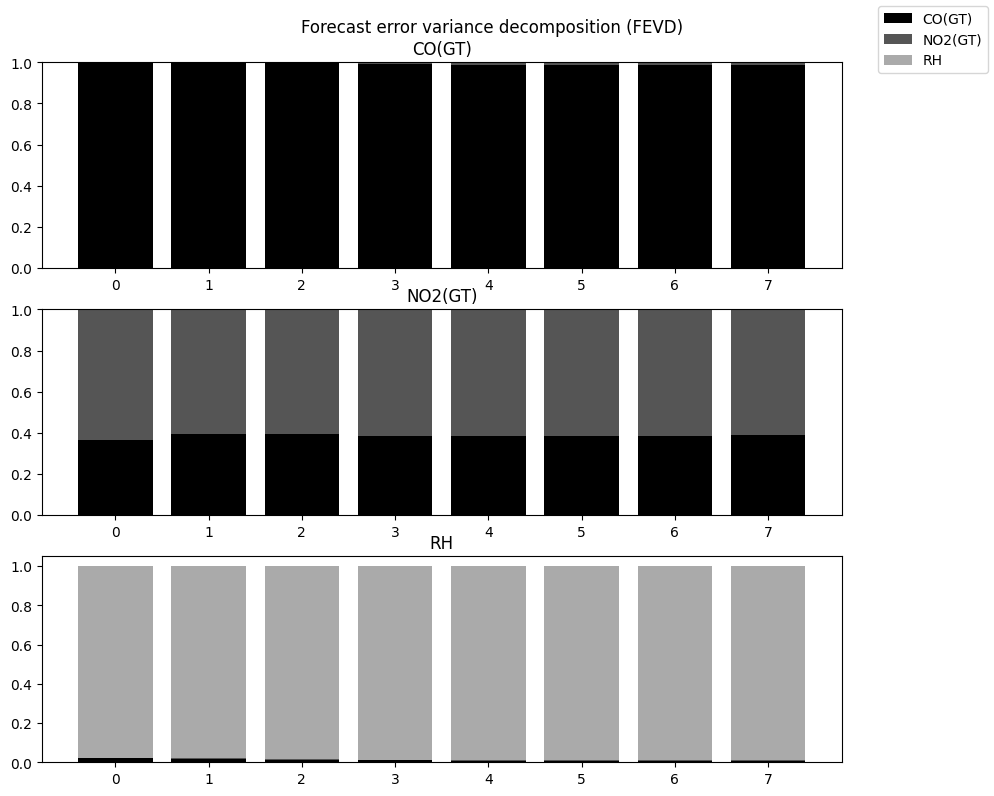

In [60]:
fevd = var_model.fevd(8)
ax = fevd.plot(figsize=(10, 8))
plt.show()

Observation/s:

- For CO, the variance is mostly explained by exogenous shocks to CO. This decreases over time but only by a small amount.

- For NO2, the variance is mostly explained by exogenous shocks to NO2 and CO.

- For RH, the variance is mostly explained by exogenous shocks to RH. Over time, the contribution of the exogenous shocks to CO increases.



<h3> Summary </h3>

- VAR methods are useful when dealing with multivariate time series, as they allow us to use the relationship between the different variable to forecast.

- These models allow us to forecast the different variables simultaneously, with the added benefit of easy (only 1 hyperparameter) and fast training.

- Using the fitted VAR model, we can also explain the relationship between variables, and how the perturbation in one variable affects the others by getting the impulse response functions and the variance decomposition of the forecasts.

<font color='red'> However, the application of these models is limited due to the stationarity requirement for ALL the variables in the multivariate time series. This method won’t work well if there is at least one variable that’s non-stationary. When dealing with non-stationary multivariate time series, one can explore the use of vector error correction models (VECM).



<h2> Granger Causality Test </h2>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

In [62]:
ipo_df = pd.read_csv('./data/Ipo_dataset.csv', index_col='Time');
ipo_df = ipo_df.dropna()
ipo_df.head()

,Rain,ONI,NIA,Dam
Time,,,,
0,0.0,-0.7,38.225693,100.70
1,0.0,-0.7,57.996530,100.63
2,0.0,-0.7,49.119213,100.56
3,0.0,-0.7,47.034720,100.55
4,0.0,-0.7,42.223380,100.48


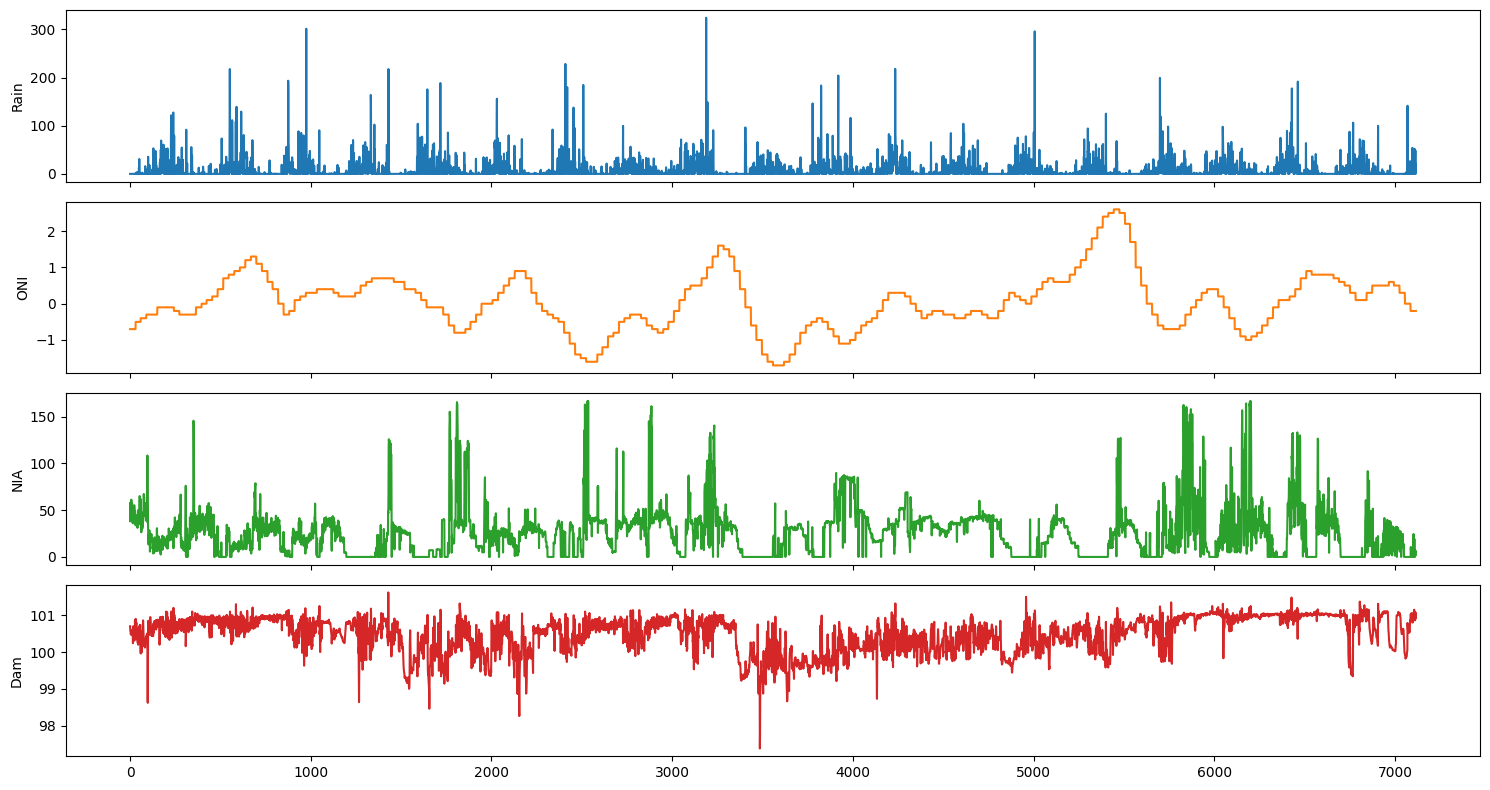

In [63]:
fig,ax = plt.subplots(4, figsize=(15,8), sharex=True)
plot_cols = ['Rain', 'ONI', 'NIA', 'Dam']
ipo_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [64]:
data_df = ipo_df.drop(['ONI', 'NIA'], axis=1)
data_df.head()

,Rain,Dam
Time,,
0,0.0,100.70
1,0.0,100.63
2,0.0,100.56
3,0.0,100.55
4,0.0,100.48


In [74]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(data_df[data_df.columns[0]], ax=ax1)
    ax1.set_title(data_df.columns[0]);

    lag_plot(data_df[data_df.columns[1]], ax=ax2)
    ax2.set_title(data_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

In [66]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [67]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0171,1.3155
p-value,0.1000,0.0100
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


Result: Rain is stationary, while Dam is not.

In [68]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [69]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.6223,-5.8742
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


Result: Both data are stationary.

Since both the lag plot and KPSS test indicate that Dam is not stationary, we apply differencing first before building our VAR model.

In [70]:
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

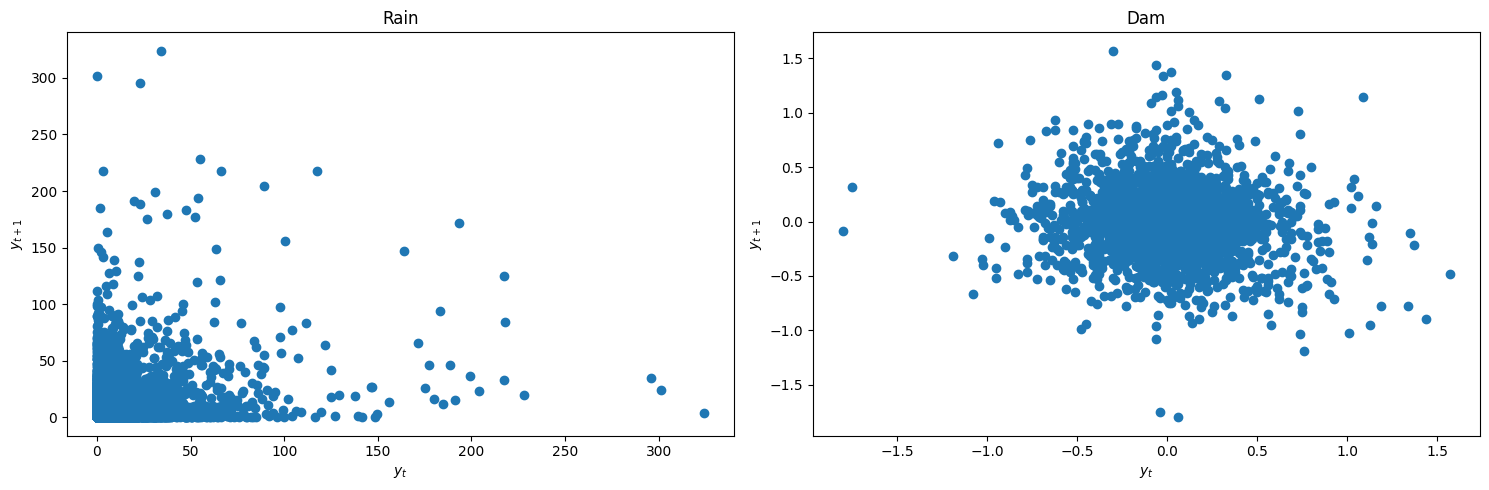

In [76]:
lag_plots(data_df)

In [77]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0171,0.0128
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [78]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.6227,-21.5919
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


Result: All three conclusively agree that both data are now stationary.

We next split the data into train and test sets for the VAR model.

In [79]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [80]:
train_df, test_df = splitter(data_df)

We then select the VAR order p by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [82]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     21
BIC      8
HQIC    11
FPE     21
dtype: int64


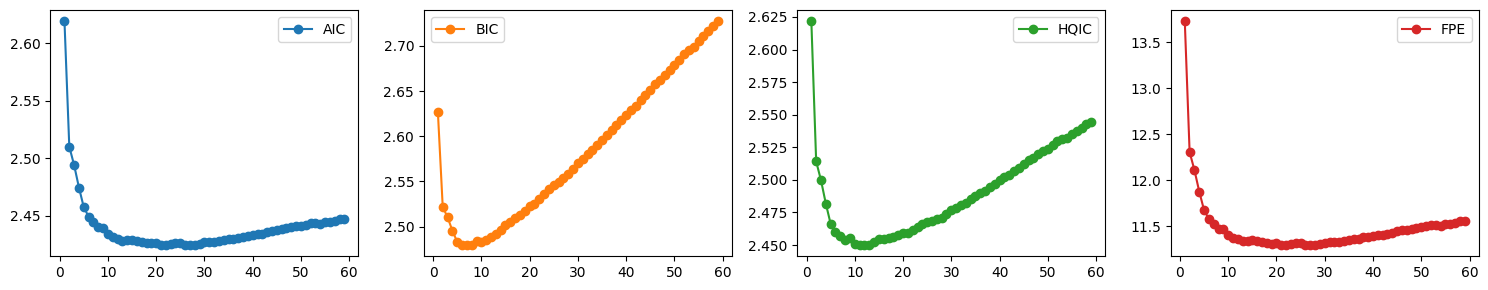

In [83]:
select_p(train_df)

<b>Result:</b> We see that BIC has the lowest value at p=8 while HQIC at p=11. Although both AIC and FPE have the lowest value at p=21, their plots also show an elbow. We can thus select the number of lags to be 8 (also for computational efficiency).

In [84]:
p = 8
model = VAR(train_df)
var_model = model.fit(p)

In [85]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [86]:
granger_causation_matrix(train_df, train_df.columns, p) 

,Rain_x,Dam_x
Rain_y,1.0,0.2169
Dam_y,0.0,1.0000


Recall: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

Results: For this particular example, we can say that rainfall Granger causes changes in the dam water level. This means that rainfall data improves changes in dam water level prediction performance.

On the other hand, changes in dam water level does not Granger cause rainfall. This means that changes in dam water level data does not improve rainfall prediction performance.



<h3> Causality between NIA Release Flow and Ipo Dam Water Level¶

In [87]:
data_df = ipo_df.drop(['ONI', 'Rain'], axis=1)
data_df.head()

,NIA,Dam
Time,,
0,38.225693,100.70
1,57.996530,100.63
2,49.119213,100.56
3,47.034720,100.55
4,42.223380,100.48


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

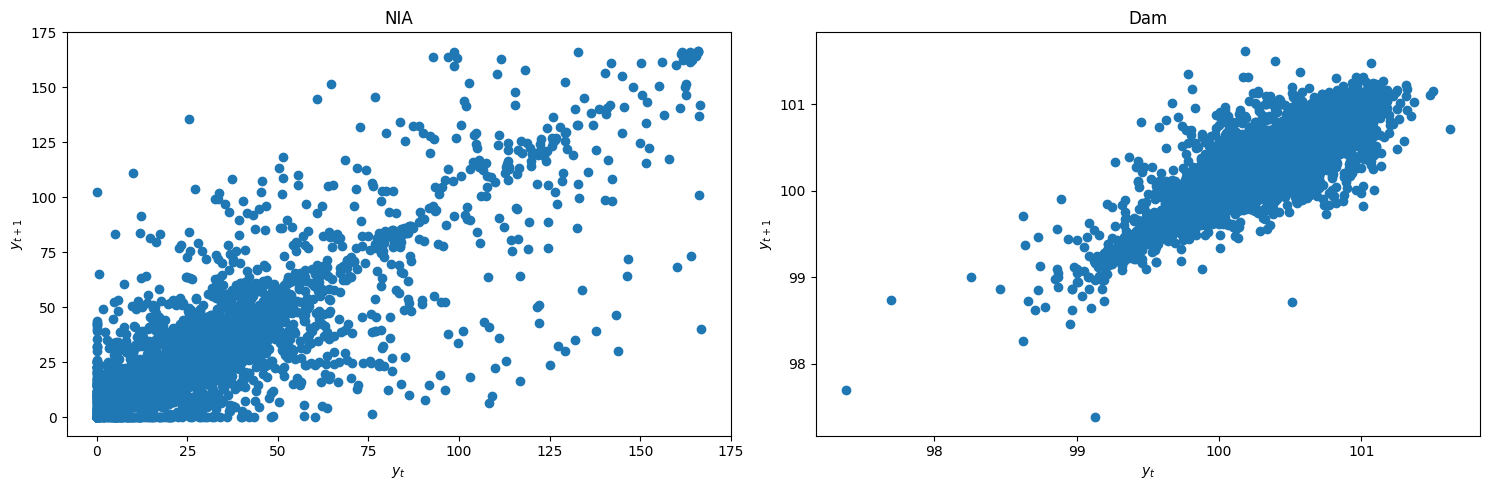

In [89]:
lag_plots(data_df)

In [90]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.1434,1.3155
p-value,0.0547,0.0100
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [91]:
adf_test(data_df)

,NIA,Dam
Test statistic,-6.6030,-5.8742
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


In [92]:
data_df['NIA'] = data_df['NIA'] - data_df['NIA'].shift(1)
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

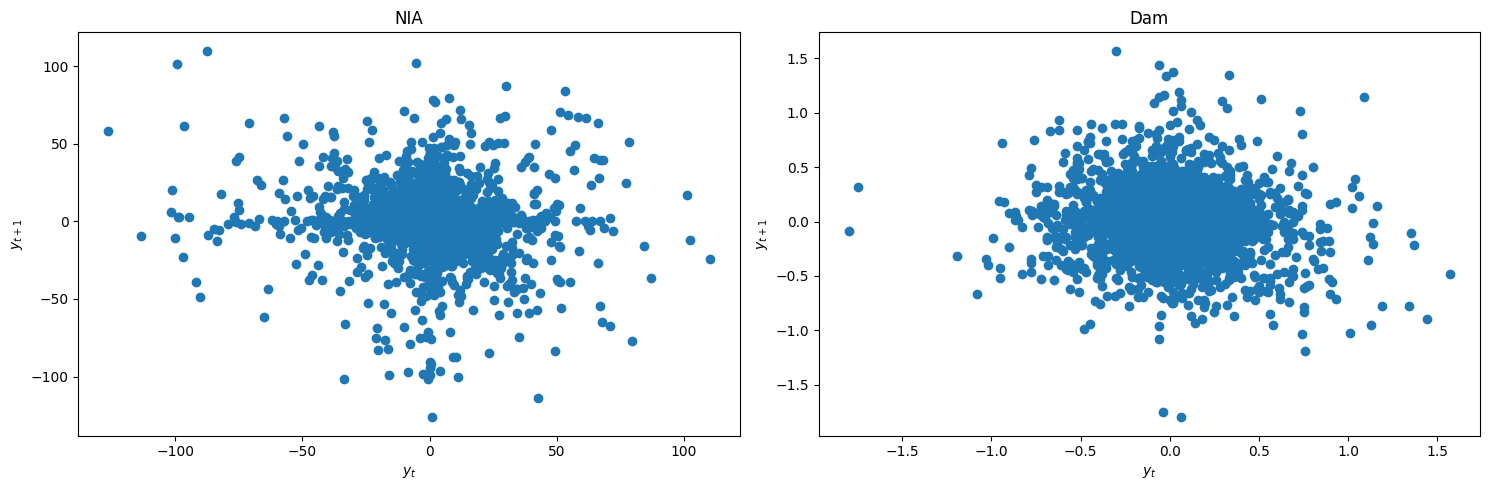

In [93]:
lag_plots(data_df)

In [94]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.0063,0.0128
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [95]:
adf_test(data_df)

,NIA,Dam
Test statistic,-21.2837,-21.5919
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

<h4> Limitations of Granger Causality </h4>

Granger Causality has its limitations.

<font color='red'> The intuition behind Granger causality is that a variable A causes B if we have a model that improves prediction of B if we include A. This framework assumes that we can “separate” the information about A from the rest of the system. However, in many systems that have interacting parts, information about a variable may not necessarily be removable from the rest of the system. They are integrated or in other words, not separable.

Granger causality framework does not apply to cases where information about variables are not separable from the rest of the system especially for those whose causalities are weak to moderate (like in our test systems in the following sections). Finally, Granger Causality is dependent on the performance of a linear predictive model that assumes linear combination of variables. This model may not perform well for some systems that need nonlinear models to improve predictions.



<h3> Convergent Cross Mapping (CCM) addresses limits of Granger causality


Convergent Cross Mapping is designed to identify and quantify causalities in systems whose variables are not separable. Beyond this, it is designed to identify and quantify weak to moderate causalities, which Granger Causality may miss. Finally, CCM is independent of a predictive model so we’re not at the mercy of model performance.
